#### Imports

In [1]:
import tensorflow as tf                                
from tensorflow import keras             
import numpy as np                       
from sklearn.model_selection import train_test_split   
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape, LSTM
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Examples:
* CNN
* CNN-LSTM

#### Preprocessing

In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
print("testing data:", X_test.shape)


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
testing data: (443, 22, 1000)


In [7]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


#### CNN

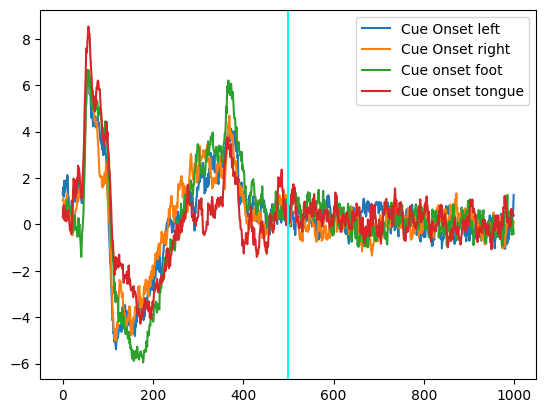

In [98]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])





In [99]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)





    



Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

In [100]:

# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 28, 1, 50)       

In [101]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate)

/Users/karimsaraipour/opt/anaconda3/envs/ee147/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [102]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/50
109/109 [==============================] - 5s 37ms/step - loss: 1.9355 - accuracy: 0.3345 - val_loss: 1.3113 - val_accuracy: 0.4260
Epoch 2/50
109/109 [==============================] - 3s 32ms/step - loss: 1.5008 - accuracy: 0.3888 - val_loss: 1.1781 - val_accuracy: 0.4873
Epoch 3/50
109/109 [==============================] - 4s 36ms/step - loss: 1.3097 - accuracy: 0.4484 - val_loss: 1.1315 - val_accuracy: 0.5087
Epoch 4/50
109/109 [==============================] - 3s 32ms/step - loss: 1.1879 - accuracy: 0.5052 - val_loss: 1.1120 - val_accuracy: 0.5240
Epoch 5/50
109/109 [==============================] - 4s 32ms/step - loss: 1.1011 - accuracy: 0.5458 - val_loss: 1.0589 - val_accuracy: 0.5613
Epoch 6/50
109/109 [==============================] - 4s 36ms/step - loss: 1.0233 - accuracy: 0.5764 - val_loss: 1.0651 - val_accuracy: 0.5460
Epoch 7/50
109/109 [==============================] - 6s 49ms/step - loss: 0.9778 - accuracy: 0.5957 - val_loss: 0.9786 - val_accuracy: 0.6207

In [103]:
cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.697516918182373


#### CNN-LSTM

In [104]:
## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)




Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

In [105]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.5))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((100))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((100,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.6, recurrent_dropout=0.1, input_shape=(100,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()







Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_28 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_28 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_30 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 28, 1, 50)       

In [106]:
# Model parameters
learning_rate = 1e-3
epochs = 50
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(lr=learning_rate)

In [107]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)



Epoch 1/50
109/109 [==============================] - 11s 83ms/step - loss: 1.3732 - accuracy: 0.3029 - val_loss: 1.3364 - val_accuracy: 0.3713
Epoch 2/50
109/109 [==============================] - 9s 80ms/step - loss: 1.3001 - accuracy: 0.3819 - val_loss: 1.2494 - val_accuracy: 0.4547
Epoch 3/50
109/109 [==============================] - 9s 84ms/step - loss: 1.2391 - accuracy: 0.4394 - val_loss: 1.1863 - val_accuracy: 0.4960
Epoch 4/50
109/109 [==============================] - 9s 84ms/step - loss: 1.2157 - accuracy: 0.4496 - val_loss: 1.1806 - val_accuracy: 0.4880
Epoch 5/50
109/109 [==============================] - 9s 83ms/step - loss: 1.1756 - accuracy: 0.4776 - val_loss: 1.1527 - val_accuracy: 0.5273
Epoch 6/50
109/109 [==============================] - 9s 84ms/step - loss: 1.1516 - accuracy: 0.4884 - val_loss: 1.1558 - val_accuracy: 0.5120
Epoch 7/50
109/109 [==============================] - 10s 92ms/step - loss: 1.1213 - accuracy: 0.5013 - val_loss: 1.1212 - val_accuracy: 0.51

In [108]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.6399548649787903


## Default Project

#### 1. Optimize the classification accuracy for subject 1. Does it help to train across all subjects?

#### Preprocessing

In [8]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

subject = 0
subject_test_idx = np.where(person_test==subject)[0]
subject_valid_idx = np.where(person_train_valid==subject)[0]


subject_X_test = X_test[subject_test_idx]
suject_y_test = y_test[subject_test_idx]
suject_X_train_valid = X_train_valid[subject_valid_idx]
suject_y_train_valid = y_train_valid[subject_valid_idx]

print(f'X_test Shape for Subject {subject}: {subject_X_test.shape}')
print(f'y_test Shape for Subject {subject}: {suject_y_test.shape}')
print(f'X_train_valid Shape for Subject {subject}: {suject_X_train_valid.shape}')
print(f'y_train_valid Shape for Subject {subject}: {suject_y_train_valid.shape}')




X_test Shape for Subject 0: (50, 22, 1000)
y_test Shape for Subject 0: (50,)
X_train_valid Shape for Subject 0: (237, 22, 1000)
y_train_valid Shape for Subject 0: (237,)


In [9]:
# shuffle with 5 fold
indicies_valid = np.random.choice(suject_X_train_valid.shape[0], suject_X_train_valid.shape[0] // 5, replace=False)
indicies_train = np.array(list(set(range(suject_X_train_valid.shape[0])).difference(set(indicies_valid))))

# Creating the training and validation sets using the generated indices
X_train, X_valid = suject_X_train_valid[indicies_train], suject_X_train_valid[indicies_valid] 
y_train, y_valid = suject_y_train_valid[indicies_train], suject_y_train_valid[indicies_valid]


# Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(subject_X_test,suject_y_test,2,2,True)



print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)



Shape of X after trimming: (190, 22, 500)
Shape of X after maxpooling: (190, 22, 250)
Shape of X after averaging+noise and concatenating: (380, 22, 250)
Shape of X after subsampling and concatenating: (760, 22, 250)
Shape of X after trimming: (47, 22, 500)
Shape of X after maxpooling: (47, 22, 250)
Shape of X after averaging+noise and concatenating: (94, 22, 250)
Shape of X after subsampling and concatenating: (188, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
Shape of training set: (760, 22, 250)
Shape of validation set: (188, 22, 250)
Shape of training labels: (760,)
Shape of validation labels: (188,)
Shape of testing set: (200, 22, 250)
Shape of testing labels: (200,)
Shape of training labels after categorical conversion: (760, 4)
Shape of validation labels after categorical conversion: (188, 4)
Shape of tes

#### Model

In [28]:

# Building the CNN model using sequential class
cnn_subject_model = Sequential()

# Conv. block 1
cnn_subject_model.add(Conv2D(filters=10, kernel_size=(5,1), padding='same', activation='elu', input_shape=(250,1,22)))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))

# Conv. block 2
cnn_subject_model.add(Conv2D(filters=10, kernel_size=(15,1), padding='same', activation='elu'))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))



# # Conv. block 4
# cnn_subject_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# # Conv. block 5
# cnn_subject_model.add(Conv2D(filters=100, kernel_size=(50,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# # Conv. block 6
# cnn_subject_model.add(Conv2D(filters=50, kernel_size=(50,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# # Conv. block 7
# cnn_subject_model.add(Conv2D(filters=25, kernel_size=(50,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# Output layer with Softmax activation
cnn_subject_model.add(Flatten()) # Flattens the input
cnn_subject_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
cnn_subject_model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 250, 1, 10)        1110      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 84, 1, 10)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 84, 1, 10)        40        
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 84, 1, 10)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 84, 1, 10)         1510      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 1, 10)       

#### Hyperparameters

In [29]:
learning_rate = 1e-3
epochs = 100
cnn_subject_model_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

#### Training

In [33]:
cnn_subject_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_subject_model_optimizer,
                 metrics=['accuracy'])

cnn_subject_model_results = cnn_subject_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True
             )

Epoch 1/100
12/12 [==============================] - 1s 26ms/step - loss: 0.1424 - accuracy: 0.9500 - val_loss: 1.3554 - val_accuracy: 0.6543
Epoch 2/100
12/12 [==============================] - 0s 23ms/step - loss: 0.1654 - accuracy: 0.9434 - val_loss: 1.2711 - val_accuracy: 0.6543
Epoch 3/100
12/12 [==============================] - 0s 15ms/step - loss: 0.1715 - accuracy: 0.9408 - val_loss: 1.4166 - val_accuracy: 0.6011
Epoch 4/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1713 - accuracy: 0.9355 - val_loss: 1.3082 - val_accuracy: 0.6649
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1564 - accuracy: 0.9382 - val_loss: 1.3320 - val_accuracy: 0.6489
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1449 - accuracy: 0.9474 - val_loss: 1.3556 - val_accuracy: 0.6489
Epoch 7/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1455 - accuracy: 0.9513 - val_loss: 1.3389 - val_accuracy: 0.6543
Epoch 

#### Testing

In [34]:
cnn_subject_model_score = cnn_subject_model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy of the CNN model for subject {subject}:',cnn_subject_model_score[1])

Test accuracy of the CNN model for subject 0: 0.7850000262260437


Now Training across all subjects

In [66]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

subject = 0
subject_test_idx = np.where(person_test==subject)[0]
subject_valid_idx = np.where(person_train_valid==subject)[0]


subject_X_test = X_test[subject_test_idx]
suject_y_test = y_test[subject_test_idx]
suject_X_train_valid = X_train_valid[subject_valid_idx]
suject_y_train_valid = y_train_valid[subject_valid_idx]

print(f'X_test Shape for Subject {subject}: {subject_X_test.shape}')
print(f'y_test Shape for Subject {subject}: {suject_y_test.shape}')
print(f'X_train_valid Shape for Subject {subject}: {suject_X_train_valid.shape}')
print(f'y_train_valid Shape for Subject {subject}: {suject_y_train_valid.shape}')

# shuffle with 5 fold
indicies_valid = np.random.choice(X_train_valid.shape[0], X_train_valid.shape[0] // 5, replace=False)
indicies_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(indicies_valid))))

# Creating the training and validation sets using the generated indices
X_train, X_valid = X_train_valid[indicies_train], X_train_valid[indicies_valid] 
y_train, y_valid = y_train_valid[indicies_train], y_train_valid[indicies_valid]


# Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(subject_X_test,suject_y_test,2,2,True)



print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)



X_test Shape for Subject 0: (50, 22, 1000)
y_test Shape for Subject 0: (50,)
X_train_valid Shape for Subject 0: (237, 22, 1000)
y_train_valid Shape for Subject 0: (237,)
Shape of X after trimming: (1692, 22, 500)
Shape of X after maxpooling: (1692, 22, 250)
Shape of X after averaging+noise and concatenating: (3384, 22, 250)
Shape of X after subsampling and concatenating: (6768, 22, 250)
Shape of X after trimming: (423, 22, 500)
Shape of X after maxpooling: (423, 22, 250)
Shape of X after averaging+noise and concatenating: (846, 22, 250)
Shape of X after subsampling and concatenating: (1692, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
Shape of training set: (6768, 22, 250)
Shape of validation set: (1692, 22, 250)
Shape of training labels: (6768,)
Shape of validation labels: (1692,)
Shape of testing set: (200, 2

In [67]:

# Building the CNN model using sequential class
cnn_subject_model = Sequential()

# Conv. block 1
cnn_subject_model.add(Conv2D(filters=10, kernel_size=(5,1), padding='same', activation='elu', input_shape=(250,1,22)))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))

# Conv. block 2
cnn_subject_model.add(Conv2D(filters=10, kernel_size=(15,1), padding='same', activation='elu'))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))



# # Conv. block 4
# cnn_subject_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# # Conv. block 5
# cnn_subject_model.add(Conv2D(filters=100, kernel_size=(50,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# # Conv. block 6
# cnn_subject_model.add(Conv2D(filters=50, kernel_size=(50,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# # Conv. block 7
# cnn_subject_model.add(Conv2D(filters=25, kernel_size=(50,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# Output layer with Softmax activation
cnn_subject_model.add(Flatten()) # Flattens the input
cnn_subject_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
cnn_subject_model.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 250, 1, 10)        1110      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 84, 1, 10)        0         
 g2D)                                                            
                                                                 
 batch_normalization_13 (Bat  (None, 84, 1, 10)        40        
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 84, 1, 10)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 84, 1, 10)         1510      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 28, 1, 10)       

In [68]:
learning_rate = 1e-3
epochs = 100
cnn_subject_model_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [69]:
cnn_subject_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_subject_model_optimizer,
                 metrics=['accuracy'])

cnn_subject_model_results = cnn_subject_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/100
106/106 [==============================] - 2s 11ms/step - loss: 1.9760 - accuracy: 0.2850 - val_loss: 1.3613 - val_accuracy: 0.4084
Epoch 2/100
106/106 [==============================] - 1s 8ms/step - loss: 1.5502 - accuracy: 0.3527 - val_loss: 1.2148 - val_accuracy: 0.4326
Epoch 3/100
106/106 [==============================] - 1s 9ms/step - loss: 1.3634 - accuracy: 0.3973 - val_loss: 1.1623 - val_accuracy: 0.4823
Epoch 4/100
106/106 [==============================] - 1s 9ms/step - loss: 1.2364 - accuracy: 0.4465 - val_loss: 1.1127 - val_accuracy: 0.5171
Epoch 5/100
106/106 [==============================] - 1s 9ms/step - loss: 1.1904 - accuracy: 0.4818 - val_loss: 1.0909 - val_accuracy: 0.5177
Epoch 6/100
106/106 [==============================] - 1s 9ms/step - loss: 1.1424 - accuracy: 0.5132 - val_loss: 1.0685 - val_accuracy: 0.5437
Epoch 7/100
106/106 [==============================] - 1s 9ms/step - loss: 1.1179 - accuracy: 0.5142 - val_loss: 1.0436 - val_accuracy: 0.577

In [70]:
cnn_subject_model_score = cnn_subject_model.evaluate(x_test, y_test, verbose=False)
print(f'Test accuracy of the CNN model for subject {subject}:',cnn_subject_model_score[1])


Test accuracy of the CNN model for subject 0: 0.7049999833106995


#### 2. Optimize the classification accuracy across all subjects. How does the classifier do? Do you notice any interesting trends?

#### Preprocessing

In [75]:
def preprocess_subjects(subject):
    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    ## Adjusting the labels so that 

    # Cue onset left - 0
    # Cue onset right - 1
    # Cue onset foot - 2
    # Cue onset tongue - 3

    y_train_valid -= 769
    y_test -= 769


    subject_test_idx = np.where(person_test==subject)[0]
    subject_valid_idx = np.where(person_train_valid==subject)[0]


    subject_X_test = X_test[subject_test_idx]
    suject_y_test = y_test[subject_test_idx]
    suject_X_train_valid = X_train_valid[subject_valid_idx]
    suject_y_train_valid = y_train_valid[subject_valid_idx]

    # print(f'X_test Shape for Subject {subject}: {subject_X_test.shape}')
    # print(f'y_test Shape for Subject {subject}: {suject_y_test.shape}')
    # print(f'X_train_valid Shape for Subject {subject}: {suject_X_train_valid.shape}')
    # print(f'y_train_valid Shape for Subject {subject}: {suject_y_train_valid.shape}')

    # shuffle with 5 fold
    indicies_valid = np.random.choice(suject_X_train_valid.shape[0], suject_X_train_valid.shape[0] // 5, replace=False)
    indicies_train = np.array(list(set(range(suject_X_train_valid.shape[0])).difference(set(indicies_valid))))

    # Creating the training and validation sets using the generated indices
    X_train, X_valid = suject_X_train_valid[indicies_train], suject_X_train_valid[indicies_valid] 
    y_train, y_valid = suject_y_train_valid[indicies_train], suject_y_train_valid[indicies_valid]


    # Preprocessing the dataset
    x_train,y_train = data_prep(X_train,y_train,2,2,True)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
    X_test_prep,y_test_prep = data_prep(subject_X_test,suject_y_test,2,2,True)



    # print('Shape of training set:',x_train.shape)
    # print('Shape of validation set:',x_valid.shape)
    # print('Shape of training labels:',y_train.shape)
    # print('Shape of validation labels:',y_valid.shape)
    # print('Shape of testing set:',X_test_prep.shape)
    # print('Shape of testing labels:',y_test_prep.shape)


    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)
    # print('Shape of training labels after categorical conversion:',y_train.shape)
    # print('Shape of validation labels after categorical conversion:',y_valid.shape)
    # print('Shape of test labels after categorical conversion:',y_test.shape)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    # print('Shape of training set after adding width info:',x_train.shape)
    # print('Shape of validation set after adding width info:',x_valid.shape)
    # print('Shape of test set after adding width info:',x_test.shape)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    # print('Shape of training set after dimension reshaping:',x_train.shape)
    # print('Shape of validation set after dimension reshaping:',x_valid.shape)
    # print('Shape of test set after dimension reshaping:',x_test.shape)

    return (x_train, y_train, x_valid, y_valid, x_test, y_test)




#### Model

In [76]:

# Building the CNN model using sequential class
cnn_subject_model = Sequential()

# Conv. block 1
cnn_subject_model.add(Conv2D(filters=10, kernel_size=(5,1), padding='same', activation='elu', input_shape=(250,1,22)))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))

# Conv. block 2
cnn_subject_model.add(Conv2D(filters=10, kernel_size=(15,1), padding='same', activation='elu'))
cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_subject_model.add(BatchNormalization())
cnn_subject_model.add(Dropout(0.5))



# # Conv. block 4
# cnn_subject_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# # Conv. block 5
# cnn_subject_model.add(Conv2D(filters=100, kernel_size=(50,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# # Conv. block 6
# cnn_subject_model.add(Conv2D(filters=50, kernel_size=(50,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# # Conv. block 7
# cnn_subject_model.add(Conv2D(filters=25, kernel_size=(50,1), padding='same', activation='elu'))
# cnn_subject_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
# cnn_subject_model.add(BatchNormalization())
# cnn_subject_model.add(Dropout(0.5))

# Output layer with Softmax activation
cnn_subject_model.add(Flatten()) # Flattens the input
cnn_subject_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
cnn_subject_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 10)        1110      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 10)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 10)        40        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 10)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 10)         1510      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 10)        0

#### Training / Testing

In [77]:
subjects = 9
for subject in range(subjects):
    tf.keras.backend.clear_session()
    learning_rate = 1e-3
    epochs = 100
    cnn_subject_model_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    x_train, y_train, x_valid, y_valid, x_test, y_test = preprocess_subjects(subject=subject)
    cnn_subject_model.compile(loss='categorical_crossentropy',
                    optimizer=cnn_subject_model_optimizer,
                    metrics=['accuracy'])

    cnn_subject_model_results = cnn_subject_model.fit(x_train,
                y_train,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid, y_valid), verbose=True)
    
    cnn_subject_model_score = cnn_subject_model.evaluate(x_test, y_test, verbose=False)
    print(f'Test accuracy of the CNN model for subject {subject}:',cnn_subject_model_score[1])



Shape of X after trimming: (190, 22, 500)
Shape of X after maxpooling: (190, 22, 250)
Shape of X after averaging+noise and concatenating: (380, 22, 250)
Shape of X after subsampling and concatenating: (760, 22, 250)
Shape of X after trimming: (47, 22, 500)
Shape of X after maxpooling: (47, 22, 250)
Shape of X after averaging+noise and concatenating: (94, 22, 250)
Shape of X after subsampling and concatenating: (188, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
Epoch 1/100
12/12 [==============================] - 1s 20ms/step - loss: 2.2608 - accuracy: 0.2421 - val_loss: 3.8544 - val_accuracy: 0.1809
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 2.0252 - accuracy: 0.3066 - val_loss: 2.7890 - val_accuracy: 0.2287
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 

#### 3. Evaluate the classification accuracy as a function of time (e.g., does it increase as you have data over longer periods of time? how much time is required to get a reasonable classification accuracy?)

#### Preprocessing

#### Model

#### Hyperparameters

#### Training

#### Testing

## Deeper Exploration and Analysis into other architectures